## Paso 0. Library import

In [1]:
!pip install flopy

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import flopy
from flopy.plot.styles import styles

from wexler1 import sol_analytical_t
from sorption_decay import *
import vflow

* The simulation consists of one stress period that is 120 $s$ in length, and the stress period is divided into 240 equally sized time steps.
* By using a uniform porosity value of 0.1, a velocity value of 0.1 $cm/s$ results from the injection of water at a rate of 0.001 $cm^3/s$ into the first cell.
* The last cell is assigned a constant head with a value of zero, though this value is not important as the cells are marked as being confined.
* The concentration of the injected water is assigned a value of 1.0, and any water that leaves through the constant-head cell leaves with the simulated concentration of the water in that last cell.
* Advection is solved using the TVD scheme to reduce numerical dispersion.

|Parameter | Value| Units | Variable |
|---:|:---:|:---:|:---|
|Number of periods |1| | `nper` |
|Number of layers |1| | `nlay` |
|Number of rows |1| | `nrow` |
|Number of columns |120| | `ncol` |
|Length of system |12.0| cm | `mesh.row_length` |
|Column width |0.1| cm | `mesh.delr` |
|Row width |0.1| cm | `mesh.delc`|
|Top of the model |1.0| cm | `mesh.top`|
|Layer bottom elevation (cm) |0| cm | `mesh.bottom` |
|Specific discharge |0.1| cm s$^{-1}$ | 
|Hydraulic conductivity |0.01| cm s$^{-1}$ |
|Porosity of mobile domain |0.1| unitless |
|Simulation time |120.0| s |
|Source concentration |1.0| unitless |
|Initial concentration |0.0| unitless |


## Step 1. Simulation parameters definition.

In [3]:
# ----- Definición de Parámetros -----
mesh = vflow.MeshDis(
    nrow = 1,    # Number of rows
    ncol = 120,  # Number of columns
    nlay = 1,    # Number of layers
    row_length = 12.0,    # Length of system ($cm$)
    column_length = 0.1,  # Length of system ($cm$)
    top = 1.0,   # Top of the model ($cm$)
    bottom = 0,  # Layer bottom elevation ($cm$)
)

tparams = dict(nper = 1,  # Number of periods
               total_time = 120.0,  # Simulation time ($s$)
               nstp = 240,   # Number of time steps
               tsmult = 1.0  # Multiplier for the length of successive time steps.
              )

model_units = {"time": "seconds",
               "length": "centimeters"}

pparams = dict(specific_discharge = 0.1,  # Specific discharge ($cm s^{-1}$)
               porosity = 0.1,  # Porosity of mobile domain (unitless)
               initial_concentration = 0.0,  # Initial concentration (unitless)
               longitudinal_dispersivity = 0.1,
               retardation_factor = 1.0,
               decay_rate =  0.0,
              )

pparams["dispersion_coefficient"] = pparams["longitudinal_dispersivity"] * pparams["specific_discharge"] / pparams["retardation_factor"]

os_params = dict(ws = os.getcwd(), # Ruta de donde estamos actualmente
                 mf6_exe = '/home/jovyan/GMMC/WMA/mf6/bin/mf6', # Ejecutable
                 name = 'transport', # Nombre de la simulación
                 budget_file = "transport.bud",
                 concentration_file="transport.ucn"
                )

# ------------------------------------
print(' Ruta hacia el ejecutable de MODFLOW 6 : {} '.format(os_params["mf6_exe"]))
print(' Ruta actual : {}'.format(os_params["ws"]))
print(' Nombre de esta simulación: {}'.format(os_params["name"]))

 Ruta hacia el ejecutable de MODFLOW 6 : /home/jovyan/GMMC/WMA/mf6/bin/mf6 
 Ruta actual : /home/jovyan/GMMC/WMA/notebooks/2_Transporte_mf6_1D
 Nombre de esta simulación: transport


In [4]:
pparams["dispersion_coefficient"]

0.010000000000000002

## Step 3. Simulation object

In [5]:
sim = flopy.mf6.MFSimulation(sim_name=os_params["name"], 
                             sim_ws=os_params["ws"], 
                             exe_name=os_params["mf6_exe"])
print(sim)

sim_name = transport
sim_path = /home/jovyan/GMMC/WMA/notebooks/2_Transporte_mf6_1D
exe_name = /home/jovyan/GMMC/WMA/mf6/bin/mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = transport





## Step 4. Time discretization object

In [6]:
flopy.mf6.ModflowTdis(sim, 
                      nper=tparams["nper"], 
                      perioddata=((tparams["total_time"], 
                                   tparams["nstp"], 
                                   tparams["tsmult"]),), 
                      time_units=model_units["time"])

package_name = transport.tdis
filename = transport.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = transport

Block options
--------------------
time_units
{internal}
('seconds')


Block dimensions
--------------------
nper
{internal}
(1)


Block perioddata
--------------------
perioddata
{internal}
(rec.array([(120., 240, 1.)],
          dtype=[('perlen', '<f8'), ('nstp', '<i8'), ('tsmult', '<f8')]))



## Step 5. IMS object (solution calculation)

In [7]:
ims = flopy.mf6.ModflowIms(sim, 
                           linear_acceleration="bicgstab")
print(ims)

package_name = ims_-1
filename = transport.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = transport

Block linear
--------------------
linear_acceleration
{internal}
(bicgstab)





## Step 6. GWT model object (flow)

In [8]:
gwt = flopy.mf6.ModflowGwt(sim, 
                           modelname=os_params["name"], 
                           save_flows=True)
print(gwt)

name = transport
model_type = gwt6
version = mf6
model_relative_path = .




## Step 7. Space discretization object

In [9]:
dis = flopy.mf6.ModflowGwtdis(gwt,
                        length_units=model_units["length"],
                        nlay=mesh.nlay,
                        nrow=mesh.nrow,
                        ncol=mesh.ncol,
                        delr=mesh.delr,
                        delc=mesh.delc,
                        top=mesh.top,
                        botm=mesh.bottom,
                       )

print(dis)

package_name = dis
filename = transport.dis
package_type = dis
model_or_simulation_package = model
model_name = transport

Block options
--------------------
length_units
{internal}
(centimeters)


Block dimensions
--------------------
nlay
{internal}
(1)

nrow
{internal}
(1)

ncol
{internal}
(120)


Block griddata
--------------------
delr
{constant 0.1}

delc
{constant 0.1}

top
{constant 1.0}

botm
{constant 0}





## Step 8. Initial conditions object

In [10]:
ic = flopy.mf6.ModflowGwtic(gwt, strt=0)
print(ic)

package_name = ic
filename = transport.ic
package_type = ic
model_or_simulation_package = model
model_name = transport

Block griddata
--------------------
strt
{constant 0}





## Step 9.

In [11]:
mst = flopy.mf6.ModflowGwtmst(gwt,
                              porosity=pparams["porosity"],
                              **get_sorption_dict(pparams["retardation_factor"]),
                              **get_decay_dict(pparams["decay_rate"], 
                                               pparams["retardation_factor"] > 1.0),
)

print(mst)

package_name = mst
filename = transport.mst
package_type = mst
model_or_simulation_package = model
model_name = transport

Block griddata
--------------------
porosity
{constant 0.1}





In [12]:
adv = flopy.mf6.ModflowGwtadv(gwt, scheme="TVD")
print(adv)

package_name = adv
filename = transport.adv
package_type = adv
model_or_simulation_package = model
model_name = transport

Block options
--------------------
scheme
{internal}
(tvd)





In [13]:
dsp = flopy.mf6.ModflowGwtdsp(
        gwt,
        xt3d_off=True,
        alh=pparams["longitudinal_dispersivity"],
        ath1=pparams["longitudinal_dispersivity"],
)

print(dsp)

package_name = dsp
filename = transport.dsp
package_type = dsp
model_or_simulation_package = model
model_name = transport

Block options
--------------------
xt3d_off
{internal}
(True)


Block griddata
--------------------
alh
{constant 0.1}

ath1
{constant 0.1}





In [14]:
pd = [
        ("GWFHEAD", "../1_Flujo_mf6_1D/flow.hds", None),
        ("GWFBUDGET", "../1_Flujo_mf6_1D/flow.bud", None),
]
    
fmi = flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)

In [15]:
sourcerecarray = [["WEL-1", "AUX", "CONCENTRATION"]]
ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
print(ssm)

package_name = ssm
filename = transport.ssm
package_type = ssm
model_or_simulation_package = model
model_name = transport

Block sources
--------------------
sources
{internal}
([('WEL-1', 'AUX', 'CONCENTRATION')])





In [16]:
obs_data = {
        "transporte.obs.csv": [
            ("X005", "CONCENTRATION", (0, 0, 0)),
            ("X405", "CONCENTRATION", (0, 0, 40)),
            ("X1105", "CONCENTRATION", (0, 0, 110)),
        ],
}

obs_package = flopy.mf6.ModflowUtlobs(
        gwt, digits=10, print_input=True, 
        continuous=obs_data
)

print(obs_package)

package_name = obs_0
filename = transport.obs
package_type = obs
model_or_simulation_package = model
model_name = transport

Block options
--------------------
digits
{internal}
(10)

print_input
{internal}
(True)


Block continuous
--------------------
continuous
{internal}
([('X005', 'CONCENTRATION', (0, 0, 0), None)
 ('X405', 'CONCENTRATION', (0, 0, 40), None)
 ('X1105', 'CONCENTRATION', (0, 0, 110), None)])





## Step X. Output object

In [17]:
oc = flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=os_params["budget_file"],
        concentration_filerecord=os_params["concentration_file"],
        saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "LAST")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
)

print(oc)

package_name = oc
filename = transport.oc
package_type = oc
model_or_simulation_package = model
model_name = transport

Block options
--------------------
budget_filerecord
{internal}
([('transport.bud',)])

concentration_filerecord
{internal}
([('transport.ucn',)])


Block period
--------------------
saverecord
{internal}
([('CONCENTRATION', 'ALL', None) ('BUDGET', 'LAST', None)])

printrecord
{internal}
([('CONCENTRATION', 'LAST', None) ('BUDGET', 'LAST', None)])





## Step 13. Write Input files.

In [18]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model transport...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package mst...
    writing package adv...
    writing package dsp...
    writing package fmi...
    writing package ssm...
    writing package obs_0...
    writing package oc...


## Step 14. Run simulation

In [19]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../mf6/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.4 02/13/2024

   MODFLOW 6 compiled Feb 13 2024 16:19:58 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall

(True, [])

## Step 15. Postprocessing

### Resultados del flujo

In [20]:
# Obtenemos los resultados de la carga hidráulica
head = flopy.utils.HeadFile(os.path.join(os_params["ws"], 
                                         "../1_Flujo_mf6_1D/flow.hds")).get_data()

# Obtenemos los resultados del BUDGET
bud  = flopy.utils.CellBudgetFile(os.path.join(os_params["ws"], "../1_Flujo_mf6_1D/flow.bud"),
                                  precision='double')
# Obtenemos las velocidades
#spdis = bud.get_data(text='DATA-SPDIS')[0]
#qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

In [21]:
print(head.shape, '\n', head[0,0])

(1, 1, 120) 
 [12.9 12.8 12.7 12.6 12.5 12.4 12.3 12.2 12.1 12.  11.9 11.8 11.7 11.6
 11.5 11.4 11.3 11.2 11.1 11.  10.9 10.8 10.7 10.6 10.5 10.4 10.3 10.2
 10.1 10.   9.9  9.8  9.7  9.6  9.5  9.4  9.3  9.2  9.1  9.   8.9  8.8
  8.7  8.6  8.5  8.4  8.3  8.2  8.1  8.   7.9  7.8  7.7  7.6  7.5  7.4
  7.3  7.2  7.1  7.   6.9  6.8  6.7  6.6  6.5  6.4  6.3  6.2  6.1  6.
  5.9  5.8  5.7  5.6  5.5  5.4  5.3  5.2  5.1  5.   4.9  4.8  4.7  4.6
  4.5  4.4  4.3  4.2  4.1  4.   3.9  3.8  3.7  3.6  3.5  3.4  3.3  3.2
  3.1  3.   2.9  2.8  2.7  2.6  2.5  2.4  2.3  2.2  2.1  2.   1.9  1.8
  1.7  1.6  1.5  1.4  1.3  1.2  1.1  1. ]


In [22]:
#print(qx.shape, '\n', qx)

NameError: name 'qx' is not defined

### Resultados del transporte

In [23]:
mf6gwt_ra = sim.get_model("transport").obs.output.obs().data
ucnobj_mf6 = sim.transport.output.concentration()

In [24]:
print(type(mf6gwt_ra), type(ucnobj_mf6))

<class 'numpy.recarray'> <class 'flopy.utils.binaryfile.HeadFile'>


In [25]:
print(mf6gwt_ra.shape)

(240,)


In [26]:
print(mf6gwt_ra)

[(  0.5, 0.28357732, 7.83140335e-15,  9.13706044e-40)
 (  1. , 0.46247052, 4.52708696e-14,  3.46785333e-38)
 (  1.5, 0.58441305, 1.83227465e-13,  6.70677030e-37)
 (  2. , 0.6720694 , 6.26002509e-13,  8.80981864e-36)
 (  2.5, 0.73741561, 1.91973810e-12,  8.83949579e-35)
 (  3. , 0.78739937, 5.44716655e-12,  7.22387376e-34)
 (  3.5, 0.82636306, 1.45939158e-11,  5.00684322e-33)
 (  4. , 0.85717974, 3.75315938e-11,  3.02624169e-32)
 (  4.5, 0.88183412, 9.39533489e-11,  1.62793618e-31)
 (  5. , 0.9017434 , 2.31377107e-10,  7.91652786e-31)
 (  5.5, 0.91794609, 5.63859491e-10,  3.52330648e-30)
 (  6. , 0.93121916, 1.36077539e-09,  1.44953370e-29)
 (  6.5, 0.94215386, 3.24155313e-09,  5.55853273e-29)
 (  7. , 0.95119818, 6.83786444e-09,  2.00048548e-28)
 (  7.5, 0.95871855, 1.47466196e-08,  6.79536933e-28)
 (  8. , 0.96499698, 3.20341224e-08,  2.18858232e-27)
 (  8.5, 0.97025649, 6.90530920e-08,  6.70682650e-27)
 (  9. , 0.9746758 , 1.46028787e-07,  1.96086854e-26)
 (  9.5, 0.97839932, 3.00783

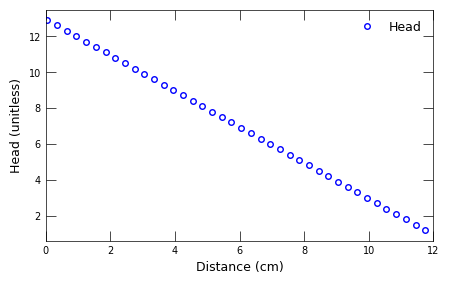

In [27]:
with styles.USGSPlot():
    plt.rcParams['font.family'] = 'DeJavu Sans'

    x, _, _ = mesh.get_coords()
    plt.figure(figsize=(5,3))
    plt.plot(x[::3], head[0, 0][::3], marker="o", ls ="none", mec="blue", mfc="none", markersize="4", label = 'Head')
    plt.xlim(0, mesh.row_length)
    plt.xlabel("Distance (cm)")
    plt.ylabel("Head (unitless)")
    plt.legend()
    plt.show()

In [28]:
simtimes = mf6gwt_ra["totim"]
simtimes.shape
print(type(simtimes), simtimes)

<class 'numpy.ndarray'> [  0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.
   6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5  12.
  12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5  18.
  18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5  24.
  24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5  30.
  30.5  31.   31.5  32.   32.5  33.   33.5  34.   34.5  35.   35.5  36.
  36.5  37.   37.5  38.   38.5  39.   39.5  40.   40.5  41.   41.5  42.
  42.5  43.   43.5  44.   44.5  45.   45.5  46.   46.5  47.   47.5  48.
  48.5  49.   49.5  50.   50.5  51.   51.5  52.   52.5  53.   53.5  54.
  54.5  55.   55.5  56.   56.5  57.   57.5  58.   58.5  59.   59.5  60.
  60.5  61.   61.5  62.   62.5  63.   63.5  64.   64.5  65.   65.5  66.
  66.5  67.   67.5  68.   68.5  69.   69.5  70.   70.5  71.   71.5  72.
  72.5  73.   73.5  74.   74.5  75.   75.5  76.   76.5  77.   77.5  78.
  78.5  79.   79.5  80.   80.5  81.   81

In [29]:
obsnames = ["X005", "X405", "X1105"]

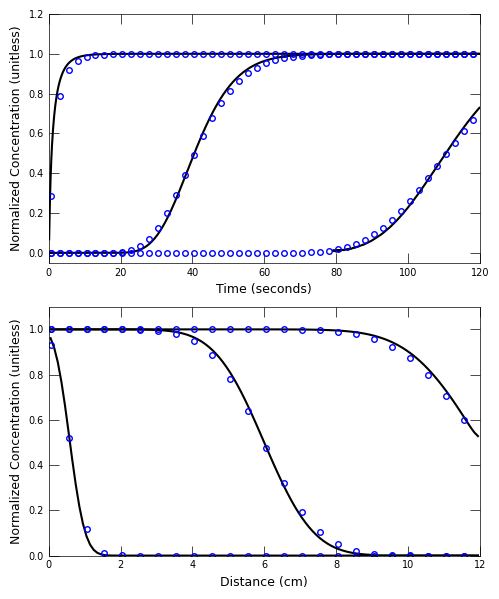

In [30]:
with styles.USGSPlot():
    plt.rcParams['font.family'] = 'DeJavu Sans'

    fig, axs = plt.subplots(2, 1, figsize=(5,6), tight_layout=True)

    iskip = 5

    atimes = np.arange(0, tparams["total_time"], 0.1)
    
    for i, x in enumerate([0.05, 4.05, 11.05]):
        a1, idx_filter = sol_analytical_t(i, x, atimes,mesh, pparams) 
                
        axs[0].plot(atimes[idx_filter], a1[idx_filter], color="k", label="ANALYTICAL")

        axs[0].plot(simtimes[::iskip], mf6gwt_ra[obsnames[i]][::iskip],
                    marker="o", ls="none", mec="blue", mfc="none", markersize="4",
                    label="MODFLOW 6")
        axs[0].set_ylim(-0.05, 1.2)
        axs[0].set_xlim(0, 120)
        axs[0].set_xlabel("Time (seconds)")
        axs[0].set_ylabel("Normalized Concentration (unitless)")
        
    ctimes = [6.0, 60.0, 120.0]

    
    x, _, _ = mesh.get_coords()
    for i, t in enumerate(ctimes):
        a1, idx_filter = sol_analytical_t(i, x, t, mesh, pparams, False)
        
        axs[1].plot(x, a1, color="k", label="ANALYTICAL")
        simconc = ucnobj_mf6.get_data(totim=t).flatten()
        axs[1].plot(x[::iskip], simconc[::iskip],
                    marker="o", ls="none", mec="blue", mfc="none", markersize="4",
                    label="MODFLOW 6")
        axs[1].set_ylim(0, 1.1)
        axs[1].set_xlim(0, 12)
        axs[1].set_xlabel("Distance (cm)")
        axs[1].set_ylabel("Normalized Concentration (unitless)")
    
    plt.show()